In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../scripts")
import models
import rnn
import pickle
from Bio import SeqIO
import os
#import main

Using TensorFlow backend.
/Users/venkatesh-sivaraman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Test the `RNNModel`

In [3]:
base_path = '/Users/venkatesh-sivaraman/Documents/School/MIT/6-047/proj/hicmotif/data/'

In [4]:
with open(os.path.join(base_path, 'epigenomic_tracks', 'GM12878.pickle'), 'rb') as file:
    id, data = pickle.load(file)

In [5]:
seq = None
for record in SeqIO.parse(os.path.join(base_path, 'loop_sequences_GM12878.fasta'), 'fasta'):
    print(record.id.replace('chr', ''), id)
    if record.id.replace('chr', '') != id: continue
    seq = models.Sequence(id, str(record.seq), data)
    break

print(len(seq.seq))

10:100225000:100425000 10:100225000:100425000
200000


In [6]:
seq_length = 100
num_examples = len(seq.seq) // seq_length
seq_array = seq.to_array()

# Generate num_examples subsequences of length seq_length with replacement
X = np.zeros((num_examples, seq_array.shape[0], seq_length))
for i in range(num_examples):
    start = np.random.randint(0, seq_array.shape[1] - seq_length)
    X[i] = seq_array[:,start:start + seq_length]

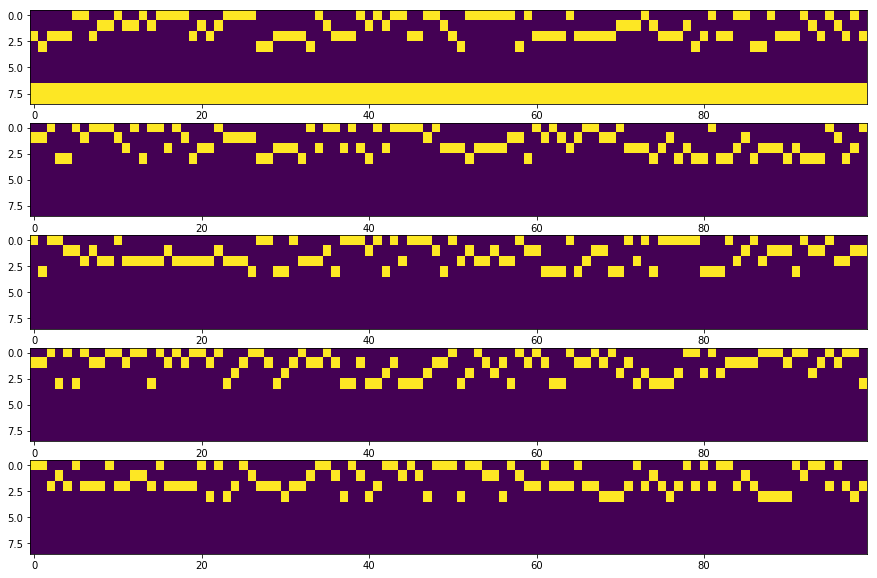

In [7]:
# Look at some of the training examples
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.imshow(X[i], aspect='auto')
plt.show()

In [8]:
#Generate random y
n_labels = 3
Y_numerical = np.random.randint(0, n_labels, size=X.shape[0])
Y = np.zeros((X.shape[0], n_labels))
for i in range(Y_numerical.shape[0]):
    Y[i,Y_numerical[i]] = 1

In [9]:
model = rnn.RNNModel(sequence_length=seq_length, n_features=X.shape[1], n_labels=n_labels)
model.create()

In [24]:
model.train(X, Y, epochs=25)

Epoch 1/25
2000/2000 [==============================] - 1s 526us/step - loss: 1.0977 - acc: 0.3440
Epoch 2/25
2000/2000 [==============================] - 1s 470us/step - loss: 1.0965 - acc: 0.3555
Epoch 3/25
2000/2000 [==============================] - 1s 479us/step - loss: 1.0945 - acc: 0.3680
Epoch 4/25
2000/2000 [==============================] - 1s 529us/step - loss: 1.0928 - acc: 0.3690
Epoch 5/25
2000/2000 [==============================] - 1s 479us/step - loss: 1.0756 - acc: 0.4100
Epoch 6/25
2000/2000 [==============================] - 1s 448us/step - loss: 1.0283 - acc: 0.4685
Epoch 7/25
2000/2000 [==============================] - 1s 514us/step - loss: 0.9450 - acc: 0.5400
Epoch 8/25
2000/2000 [==============================] - 1s 459us/step - loss: 0.8764 - acc: 0.5655
Epoch 9/25
2000/2000 [==============================] - 1s 521us/step - loss: 0.8037 - acc: 0.6130
Epoch 10/25
2000/2000 [==============================] - 1s 505us/step - loss: 0.7268 - acc: 0.6570
Epoch 11/

In [11]:
model.model

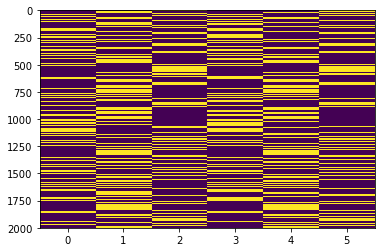

In [25]:
Y_pred = model.model.predict(X)
Y_pred = np.where(Y_pred == np.max(Y_pred, axis=1).reshape(-1, 1), 1, 0)
plt.imshow(np.hstack([Y, Y_pred]), aspect='auto')